<a href="https://colab.research.google.com/github/DFwJZ/Real-time_Bot_Detection/blob/main/Cresci2015_OCSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# root_path = "/content/drive/MyDrive/Bot_detection/cresÍci tweets/cresci 2015"

# Jason's file path
root_path = "notebooks/data"

In [ ]:
!pwd

/notebooks/notebooks


In [ ]:
%cd ..

/notebooks


In [ ]:
!ls

CITATION.cff	    README_hd.md	     docs	     setup.py
CODE_OF_CONDUCT.md  README_ja.md	     examples	     src
CONTRIBUTING.md     README_ko.md	     hubconf.py      templates
ISSUES.md	    README_zh-hans.md	     model_cards     tests
LICENSE		    README_zh-hant.md	     notebooks	     utils
Makefile	    awesome-transformers.md  pyproject.toml
README.md	    conftest.py		     scripts
README_es.md	    docker		     setup.cfg


In [ ]:
# df_total_fake = np.load('/content/drive/MyDrive/Bot_detection/cresci tweets/cresci 2015/fake_embeddings_combined_400k.npy')
# df_total_genuine = np.load('/content/drive/MyDrive/Bot_detection/cresci tweets/cresci 2015/genuine_embeddings_combined_400k.npy')
df_total_fake = np.load(f'{root_path}/fake_embeddings_combined_400k.npy')
df_total_genuine = np.load(f'{root_path}/genuine_embeddings_combined_400k.npy')

In [ ]:
print("Total bots:",len(df_total_fake))
print("Total Humans:",len(df_total_genuine))

Total bots: 395987
Total Humans: 399321


In [ ]:
# This is the feature vector that goes to the neural net
  #The whole array goes in


from sklearn.model_selection import train_test_split

fake_train, fake_test = train_test_split(
        df_total_fake, test_size=0.2, random_state=42)

print(f"bot train count: {len(fake_train)}")
print(f"bot test count: {len(fake_test)}")

bot train count: 316789
bot test count: 79198


train data = 80% of bot tweet

- train accuracy determined by 20% of bot tweets (unseen)

test accuracy 100% human tweet (accuracy is reversed) (aka we want low)

###OCSVM Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import StandardScaler

In [ ]:
fake_train

array([[ 0.42161375,  0.24456975, -0.12698323, ..., -0.03110121,
         0.27584806,  0.05251782],
       [ 0.33703452,  0.05036569, -0.05794121, ..., -0.17393969,
         0.29939273,  0.20818993],
       [ 0.3787974 ,  0.01040361, -0.09097986, ..., -0.09276678,
         0.40695712,  0.16251756],
       ...,
       [ 0.30567703,  0.19183443, -0.04613812, ...,  0.04690658,
         0.30151853,  0.15685706],
       [ 0.36703116,  0.14140385,  0.04873623, ...,  0.05519304,
         0.3806806 ,  0.16041802],
       [ 0.30986986,  0.15214097, -0.12487481, ..., -0.23122038,
         0.28825495,  0.12712464]], dtype=float32)

In [ ]:
ocsvm = svm.OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')

# Train the model
ocsvm.fit(fake_train)
import joblib
# filename = '/content/drive/MyDrive/Bot_detection/cresci tweets/ocsvm_model_jason.joblib'
filename = f'{root_path}/ocsvm_model_jason_727.joblib'
joblib.dump(ocsvm, filename)

In [ ]:
ocsvm = joblib.load(f'{root_path}/ocsvm_model.joblib')

In [ ]:
# Predict the class of the training data
predictions_train = ocsvm.predict(fake_train_test)

In [ ]:
fake_train_labels = np.full(len(fake_train_test), 1)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Accuracy Score for Train Bot Set:", accuracy_score(fake_train_labels, predictions_train))
print("Precision Score for Train Bot Set:", precision_score(fake_train_labels, predictions_train))
print("Recall Score for Train Bot Set:", recall_score(fake_train_labels, predictions_train))
print("F1 Score for Train Bot Set:", f1_score(fake_train_labels, predictions_train))

Accuracy Score for Train Bot Set: 0.89997
Precision Score for Train Bot Set: 1.0
Recall Score for Train Bot Set: 0.89997
F1 Score for Train Bot Set: 0.9473518002915835


In [ ]:
#Accuracy on Bot Tweets Test Set
fake_test_labels = np.full(len(fake_test), 1)

# Predict anomaly scores (-1 for anomalies, 1 for normal data points)
prediction_fake_test = ocsvm.predict(fake_test)

print("Accuracy Score for Test Bot Set:", accuracy_score(fake_test_labels, prediction_fake_test))
print("Precision Score for Test Bot Set:", precision_score(fake_test_labels, prediction_fake_test))
print("Recall Score for Test Bot Set:", recall_score(fake_test_labels, prediction_fake_test))
print("F1 Score for Test Bot Set:", f1_score(fake_test_labels, prediction_fake_test))

Accuracy Score for Test Bot Set: 0.8987221899542918
Precision Score for Test Bot Set: 1.0
Recall Score for Test Bot Set: 0.8987221899542918
F1 Score for Test Bot Set: 0.9466600166251039


In [ ]:
#Accuracy on Human Tweets
genuine_test = df_total_genuine[:10000]

predictions_new = ocsvm.predict(genuine_test)

genuine_train_labels = np.full(len(genuine_test), -1)

print("Accuracy Score for Human Set:", accuracy_score(genuine_train_labels, predictions_new))

Accuracy Score for Human Set: 0.9439


In [ ]:
bot = 0
for pre in predictions_new:
  if pre == 1:
    bot+=1

print(bot)

9439


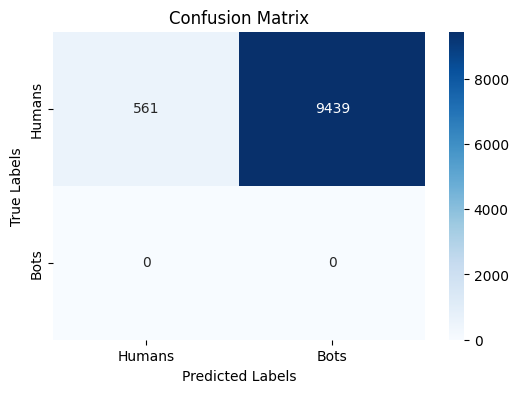

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(genuine_train_labels, predictions_new)

# Define class labels (e.g., 'Positive' and 'Negative')
class_labels = ['Humans', 'Bots']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()